In [10]:
#!git clone https://github.com/mdepres/graph_neural_net

In [33]:
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From github.com:mdepres/graph_neural_net
   bf130b1..3a07f6b  main       -> origin/main
Updating bf130b1..3a07f6b
Fast-forward
 models/trainers.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [9]:
#%cd graph_neural_net/
#!ls

/home/jovyan/graph_neural_net/graph_neural_net
commander_explore.py		  LICENSE		       qap
data_benchmarking_gnns		  loaders		       README.md
default_config.yaml		  maskedtensors		       requirements.txt
finetune_FGNN_for_coloring.ipynb  models		       toolbox
images				  plot_accuracy_regular.ipynb


In [13]:
#!pip install -r requirements.txt


[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import sys
from pathlib import Path
import math
import json
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import importlib
import networkx
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from toolbox import losses
from toolbox.losses import coloring_loss, triplet_loss
from toolbox import metrics
from loaders.loaders import siamese_loader, node_classif_loader
from toolbox.metrics import all_losses_acc, accuracy_linear_assignment
from toolbox.utils import check_dir
from models import finetuning_models, get_siamese_model_test
from models import utils
from loaders import data_generator
importlib.reload(data_generator)
from loaders.data_generator import KCOL_Generator, QAP_Generator, MBS_Generator, DC_Generator

np.set_printoptions(threshold=sys.maxsize)

/home/mdepres/miniconda3/envs/py39/lib/python3.9/site-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
/home/mdepres/miniconda3/envs/py39/lib/python3.9/site-packages/pytorch_lightning/loggers/neptune.py:39: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  from neptune import new as neptune


In [3]:
import wandb
wandb.login()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [3]:
def get_device_config(model_path):
    """ Get the same device as used for training the pretrained model """
    config_file = os.path.join(model_path,'config.json')
    with open(config_file) as json_file:
        config_model = json.load(json_file)
    use_cuda = not config_model['cpu'] and torch.cuda.is_available()
    device = 'cuda' if use_cuda else 'cpu'
    return config_model, device

def compute_dataset(args,path_dataset,train=True,bs=10):
    """ Computes some examples for the task
        - args : 'data' part of the config file
        - path_dataset : path to which the dataset will be saved, to use it several times
        - train : True if this is a training dataset, False otherwise
        - bs : desired batch size"""
    num_batches = math.ceil(args['num_examples_val']/bs)
    if train:
        gene = MBS_Generator('train', args, path_dataset)
    else:
        gene = MBS_Generator('test', args, path_dataset)
    gene.load_dataset()
    #loader = siamese_loader(gene, bs, gene.constant_n_vertices)
    loader = node_classif_loader(gene, bs, gene.constant_n_vertices)
    return loader

def is_coloring(graph, coloring):
    """ Computes the number of edges incompatible in the given coloring
    This is used as a measure of accuract for the coloring problem """
    score = 0 #Number of contradictions
    n_edges = 0
    for i in range(len(graph)):
        for j in range(len(graph)):
            if graph[i][j]==1 :
                n_edges+=1
                if coloring[i]==coloring[j]:
                    score+=1
    return score/n_edges # Percentage of errors

def is_cycle(graph,classif):
    """ Computes whether a classification highlights a cycle or not """
    # Networkx does not support creating a graph from its adjacency? Let's do it by hand
    G = networkx.graph()
    
    cycle = []
    for i in range(len(classif)):
        if classif[i]:
            cycle.append(i)
    H = graph.subgraph(cycle)
    l = networkx.simple_cycles(H)
    print(l)

def train_epoch(model, embed_model, train_loader, loss_fn, optimizer):
    """ Train the model for one epoch 
        - model : the model to be trained
        - embed_model : the pretrained model, which has a node embedder
        - train_loader : the dataset
        - loss_fn : the loss function to use for this task
        - optimizer : an initialized optimizer instance """
    model.train()
    cum_loss = 0
    for idx, (graph,tgt) in enumerate(train_loader):
        graph['input'] = graph['input'].to(device)
        
        embed = embed_model.node_embedder(graph)['ne/suffix']
        embed = torch.permute(embed,(0,2,1)) #add some dummy dimensions/Add adjacency
        
        print(embed.shape, graph['input'].shape)
        
        inp = torch.cat((torch.permute(graph['input'],(0,2,3,1))[:,:,:,0],embed), 2)
        
        tgt = tgt['input'].type(torch.LongTensor).to(device)
        
        out = model(inp)
        out = out.view((-1,out.shape[-1])) # The dependency of nodes to graph is irrelevant now
        
        tgt = tgt.view((-1,))
        
        optimizer.zero_grad()

        loss = loss_fn(out,tgt) #loss_fn(graph['input'], out, tgt)
        loss.backward()

        optimizer.step()
        cum_loss += loss.item()
    return cum_loss / len(train_loader)


def evaluate(model, embed_model, val_loader, compute_score=True):
    """ Evaluate the model at some point in the training
        - model : the model being trained
        - embed_molde : the pretrained model whose embeddings we use
        - val_loader : the dataset
        (- compute_score : do we compute an accuracy Broken)"""
    model.eval()
    cum_loss = 0
    cum_acc = 0
    for idx, (graph, tgt) in (enumerate(valid_loader)):
        graph['input'] = graph['input'].to(device)
        embed = embed_model.node_embedder(graph)['ne/suffix']
        embed = torch.permute(embed,(0,2,1)) #Add the same dummy dimensions/Add adjacency?
        
        inp = torch.cat((torch.permute(graph['input'],(0,2,3,1))[:,:,:,0],embed), 2)
        
        tgt = tgt['input'].type(torch.LongTensor).to(device)
        
        out = model(inp)
        out = out.view((-1,out.shape[-1]))
        
        tgt = tgt.view((-1,))
        
        loss = loss_fn(out, tgt)
        cum_loss += loss.item()
        
        o = out.cpu().detach().numpy()
        t = tgt.cpu().detach().numpy()
        cum_acc += accuracy_score(np.argmax(o,axis=1),t)
    print(cum_acc / len(val_loader))
    return cum_loss / len(val_loader)

def predict(model, embed_model, adj):
    """ Show the result of the model on one example """
    graph = {'input':adj.to(device)}
    embed = embed_model.node_embedder(graph)['ne/suffix']
    embed = torch.permute(embed,(0,2,1))
    
    inp = torch.cat((torch.permute(graph['input'],(0,2,3,1))[:,:,:,0],embed), 2)
    
    out = model(inp)
    return out

## Loading the pretrained model

In [16]:
cwd = os.getcwd()
#cwd = "/".join(cwd.split("/")[:-1])

In [17]:
model_path = cwd + '/qap/expe_new/node_embedding_rec_Regular_150_0.05/05-15-23-16-14'
config_model, device = get_device_config(model_path)
load_path = model_path + '/qap_expe_new/aqljez5s/checkpoints/epoch=9-step=6250.ckpt'
embed_model = get_siamese_model_test(load_path) #config_model["data"]["test"]["path_model"])
embed_model.to(device)

Siamese_Node_Exp(
  (node_embedder): Network(
    (ne_bm_in): GraphNorm()
    (ne_bm_block1_mlp3): MlpBlock_Real(
      (convs): ModuleList(
        (0): Conv2d(2, 64, kernel_size=(1, 1), stride=(1, 1))
        (1-2): 2 x Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (gn): GraphNorm()
    )
    (ne_bm_cat1): Concat()
    (ne_bm_block2_mlp1): MlpBlock_Real(
      (convs): ModuleList(
        (0): Conv2d(66, 64, kernel_size=(1, 1), stride=(1, 1))
        (1-2): 2 x Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (gn): GraphNorm()
    )
    (ne_bm_block2_mlp2): MlpBlock_Real(
      (convs): ModuleList(
        (0): Conv2d(66, 64, kernel_size=(1, 1), stride=(1, 1))
        (1-2): 2 x Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (gn): GraphNorm()
    )
    (ne_bm_block2_mult): Matmul()
    (ne_bm_block2_cat): Concat()
    (ne_bm_block2_mlp3): MlpBlock_Real(
      (convs): ModuleList(
        (0): Conv2d(130, 64, kernel_size=(1, 1), stride

## Generating data and loaders

In [20]:
config_model["data"]["test"]['connection_density'] = 0.01
config_model["data"]["test"]['edge_density'] = 0.7
config_model["data"]["test"]["num_examples_train"] = 1000
config_model["data"]["test"]["num_examples_val"] = 100
config_model["data"]["test"]["n_vertices"] = 100

In [22]:
args = config_model["data"]["test"]
train_loader = compute_dataset(args, cwd+'/experiments-gnn/mbs/data')
valid_loader = compute_dataset(args, cwd+'/experiments-gnn/mbs/data', train=False)

Creating dataset at /home/mdepres/graph_neural_net/experiments-gnn/mbs/data/MBS_ErdosRenyi_1000_100_1.0_0.7/train.pkl


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [01:27<00:00, 11.47it/s]


Saving dataset at /home/mdepres/graph_neural_net/experiments-gnn/mbs/data/MBS_ErdosRenyi_1000_100_1.0_0.7/train.pkl
Creating dataset at /home/mdepres/graph_neural_net/experiments-gnn/mbs/data/MBS_ErdosRenyi_1000_100_1.0_0.7/test.pkl


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [01:27<00:00, 11.43it/s]


Saving dataset at /home/mdepres/graph_neural_net/experiments-gnn/mbs/data/MBS_ErdosRenyi_1000_100_1.0_0.7/test.pkl


In [23]:
gene = MBS_Generator('train', args, cwd+'/experiments-gnn/mbs/data')
graph = gene.compute_example()[0][0].cpu().detach().numpy()

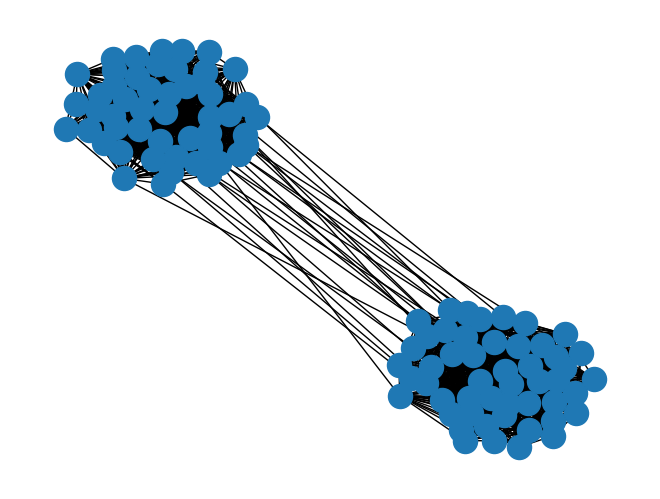

In [24]:
networkx.draw(networkx.from_numpy_array(graph))

## Training a logistic regression

In [25]:
clf = SGDClassifier(loss='log_loss', warm_start=True)

for idx, graph in enumerate(train_loader):
    graph['input'] = graph['input'].to(device)
    embed = embed_model.node_embedder(graph)['ne/suffix']
    
    embed = embed.cpu().detach().numpy()
    embed = np.swapaxes(embed,1,2)
    embed = np.resize(embed, (embed.shape[0]*embed.shape[1],embed.shape[-1]))
    embed = np.hstack((embed,np.random.random((embed.shape[0],5))*np.max(embed)))
    #g = graph['input'].cpu().detach().numpy()[:,0,:,:]
    #g = np.resize(g, (g.shape[0]*g.shape[2],g.shape[-1]))
    #embed = np.hstack((g,embed)) 
    tgt = graph['target']
    tgt = np.resize(tgt, (tgt.shape[0]*tgt.shape[1],))
    
    clf.partial_fit(embed, tgt, classes=np.arange(2))

input [] dict_keys(['input', 'target'])
ne/in ['input'] dict_keys(['input', 'target'])
ne/bm/in ['ne/in'] dict_keys(['input', 'target', 'ne/in'])
ne/bm/block1/in ['ne/bm/in'] dict_keys(['input', 'target', 'ne/in', 'ne/bm/in'])
ne/bm/block1/mlp3 ['ne/bm/block1/in'] dict_keys(['input', 'target', 'ne/in', 'ne/bm/in', 'ne/bm/block1/in'])
ne/bm/cat1 ['ne/bm/in', 'ne/bm/block1/mlp3'] dict_keys(['input', 'target', 'ne/in', 'ne/bm/in', 'ne/bm/block1/in', 'ne/bm/block1/mlp3'])
ne/bm/block2/in ['ne/bm/cat1'] dict_keys(['input', 'target', 'ne/in', 'ne/bm/in', 'ne/bm/block1/in', 'ne/bm/block1/mlp3', 'ne/bm/cat1'])
ne/bm/block2/mlp1 ['ne/bm/block2/in'] dict_keys(['input', 'target', 'ne/in', 'ne/bm/in', 'ne/bm/block1/in', 'ne/bm/block1/mlp3', 'ne/bm/cat1', 'ne/bm/block2/in'])
ne/bm/block2/mlp2 ['ne/bm/block2/in'] dict_keys(['input', 'target', 'ne/in', 'ne/bm/in', 'ne/bm/block1/in', 'ne/bm/block1/mlp3', 'ne/bm/cat1', 'ne/bm/block2/in', 'ne/bm/block2/mlp1'])
ne/bm/block2/mult ['ne/bm/block2/mlp1', 'ne

AttributeError: 'MaskedTensor' object has no attribute 'cpu'

In [12]:
acc = 0
edge_score = 0

for idx, (graph,tgt) in enumerate(valid_loader):
    graph['input'] = graph['input'].to(device)
    embed = embed_model.node_embedder(graph)['ne/suffix']
    
    embed = embed.cpu().detach().numpy()
    embed = np.swapaxes(embed,1,2)    
    embed = np.resize(embed, (embed.shape[0]*embed.shape[1],embed.shape[-1]))
    embed = np.hstack((embed,np.random.random((embed.shape[0],5))*np.max(embed))) 
    #g = graph['input'].cpu().detach().numpy()[:,0,:,:]
    #g = np.resize(g, (g.shape[0]*g.shape[2],g.shape[-1]))
    #embed = np.hstack((g,embed)) 
    tgt = tgt['input']
    tgt = np.resize(tgt, (tgt.shape[0]*tgt.shape[1],))
    
    #is_cycle(graph['input'],tgt)
    
    pred = clf.predict(embed)
    for e in range(graph['input'].shape[0]): #For each graph in the batch
        adj = graph['input'][e]
        n_v = config_model["data"]["test"]["n_vertices"]
        #edge_score += is_coloring(adj[0],pred[e*n_v:(e+1)*n_v])
    print(accuracy_score(pred,tgt))
    acc+=accuracy_score(pred,tgt)

print(acc/idx, edge_score/idx)

0.737
0.545
0.525
0.437
0.543
0.52
0.484
0.694
0.399
0.245
0.328
0.256
0.367
0.578
0.222
0.572
0.377
0.455
0.523
0.61
0.404
0.648
0.604
0.643
0.451
0.372
0.295
0.534
0.584
0.601
0.428
0.437
0.581
0.621
0.303
0.48
0.455
0.566
0.328
0.375
0.572
0.367
0.704
0.642
0.67
0.494
0.528
0.507
0.292
0.705
0.444
0.498
0.465
0.814
0.504
0.546
0.636
0.611
0.421
0.622
0.663
0.328
0.324
0.379
0.683
0.582
0.295
0.352
0.429
0.481
0.506
0.396
0.571
0.341
0.56
0.216
0.599
0.369
0.39
0.325
0.729
0.635
0.514
0.519
0.231
0.422
0.63
0.568
0.429
0.353
0.41
0.574
0.581
0.468
0.277
0.262
0.295
0.544
0.573
0.467
0.48928282828282843 0.0


## Training the coloring model

In [14]:
model = finetuning_models.ClassifierModel(args['n_vertices'],embed_dim=args['n_vertices']+64, k=2, hidden_dim = 128)#args["k"])
model.to(device)

ClassifierModel(
  (mlp1): Linear(in_features=164, out_features=128, bias=True)
  (mlp2): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=-1)
)

In [10]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 30
for epoch in range(1, num_epochs+1):
    start_time = time.time()
    train_loss = train_epoch(model, embed_model, train_loader,loss_fn,optimizer)
    end_time = time.time()
    val_loss = evaluate(model, embed_model, valid_loader)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "
          f"Epoch time = {(end_time - start_time):.3f}s"))

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

0.5000799999999999
Epoch: 4, Train loss: 346.425, Val loss: 346.693, Epoch time = 27.979s
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Siz

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

0.5006
Epoch: 8, Train loss: 346.348, Val loss: 346.719, Epoch time = 27.845s
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 6

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

0.4995400000000003
Epoch: 12, Train loss: 346.289, Val loss: 346.735, Epoch time = 27.826s
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Si

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

0.5013800000000002
Epoch: 16, Train loss: 346.219, Val loss: 346.709, Epoch time = 27.904s
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Si

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

0.5000599999999998
Epoch: 20, Train loss: 346.143, Val loss: 346.767, Epoch time = 28.032s
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Si

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

0.50076
Epoch: 24, Train loss: 346.045, Val loss: 346.780, Epoch time = 27.682s
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50,

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

0.49853999999999987
Epoch: 28, Train loss: 345.936, Val loss: 346.924, Epoch time = 27.848s
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.S

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50, 50])
torch.Size([10, 50, 64]) torch.Size([10, 2, 50

In [23]:
predict(model,embed_model,torch.tensor([[0.,1.,1.,0.,0.,0.], [1.,0.,1.,0.,0.,0.], [1.,1.,0.,0.,0.,0.], [0.,0.,0.,0.,1.,1.], [0.,0.,0.,1.,0.,1.],[0.,0.,0.,1.,1.,0.]]))

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 4

In [40]:
adj = torch.tensor([[0.,1.,1.,0.,0.,0.],
                    [1.,0.,0.,1.,0.,0.],
                    [1.,0.,0.,0.,1.,0.],
                    [0.,1.,0.,0.,0.,1.],
                    [0.,0.,1.,0.,0.,1.],
                    [0.,0.,0.,1.,1.,0.]])
graph = {'input':adj.to(device)}
a = embed_model.node_embedder(graph)['ne/suffix']
#a = torch.permute(a,(0,2,1))

In [41]:
adj = torch.tensor([[0.,1.,1.,0.,0.,0.],
                    [1.,0.,1.,0.,0.,0.],
                    [1.,1.,0.,0.,0.,0.],
                    [0.,0.,0.,0.,1.,1.],
                    [0.,0.,0.,1.,0.,1.],
                    [0.,0.,0.,1.,1.,0.]])
graph = {'input':adj.to(device)}
b = embed_model.node_embedder(graph)['ne/suffix']
#b = torch.permute(b,(0,2,1))

In [42]:
loss_fn(a,b)

tensor(427.0795, device='cuda:0', grad_fn=<NegBackward0>)

In [43]:
b

tensor([[[ 0.4402,  0.4402,  0.4402,  0.4402,  0.4402,  0.4402],
         [ 0.4009,  0.4009,  0.4009,  0.4010,  0.4009,  0.4009],
         [ 0.4204,  0.4204,  0.4204,  0.4204,  0.4204,  0.4204],
         [ 0.0847,  0.0847,  0.0847,  0.0847,  0.0847,  0.0847],
         [ 0.3063,  0.3063,  0.3063,  0.3063,  0.3063,  0.3063],
         [ 0.0539,  0.0539,  0.0539,  0.0539,  0.0539,  0.0539],
         [ 0.2470,  0.2470,  0.2470,  0.2470,  0.2470,  0.2470],
         [ 0.5839,  0.5839,  0.5839,  0.5839,  0.5839,  0.5839],
         [ 0.2048,  0.2048,  0.2048,  0.2048,  0.2048,  0.2048],
         [ 0.5894,  0.5894,  0.5894,  0.5894,  0.5894,  0.5894],
         [ 0.2026,  0.2026,  0.2026,  0.2026,  0.2026,  0.2026],
         [ 0.2651,  0.2651,  0.2651,  0.2651,  0.2651,  0.2651],
         [ 0.3780,  0.3780,  0.3780,  0.3780,  0.3780,  0.3780],
         [ 0.0116,  0.0116,  0.0116,  0.0116,  0.0116,  0.0116],
         [ 0.1653,  0.1653,  0.1653,  0.1653,  0.1653,  0.1653],
         [ 0.3254,  0.325

In [20]:
adj = torch.tensor([[0.,1.,0.,1.,0.,0.],[1.,0.,1.,0.,1.,0.],[0.,1.,0.,0.,0.,1.],[1.,0.,0.,0.,1.,0.],[0.,1.,0.,1.,0.,1.],[0.,0.,1.,0.,1.,0.]])
predict(model, embed_model, adj)

tensor([[[ 0.5876,  0.3406,  0.2466,  0.2042,  0.5165,  0.3910,  0.4041,
           0.2596,  0.3764,  0.2289,  0.5486,  0.2175,  0.2678,  0.4765,
           0.1607,  0.5217,  0.2615,  0.0721,  0.0830,  0.4413,  0.5251,
           0.2456,  0.2534,  0.5228,  0.3429,  0.1875,  0.5983,  0.6452,
           0.5067,  0.3438,  0.2812,  0.2997,  0.3568,  0.5723,  0.3633,
           0.1703,  0.5524,  0.3218,  0.3659,  0.7511,  0.1907,  0.4892,
           0.4102,  0.3257,  0.3389,  0.3946,  0.4401,  0.1967,  0.2710,
           0.3492,  0.3172,  0.4290,  0.3768,  0.1926,  0.6328,  0.2215,
           0.2491,  0.3007,  0.3100,  0.3219,  0.3196,  0.1653,  0.3739,
           0.3907],
         [ 0.2488,  0.7574,  0.1916,  0.0957,  0.2733,  0.2073,  0.4112,
           0.4048, -0.1448,  0.5541,  0.0497,  0.0351,  0.2117, -0.0638,
           0.0870, -0.0973, -0.1115,  0.7538,  0.1979,  0.1233, -0.0699,
          -0.0465,  0.4094,  0.0853,  0.3693,  0.7197,  0.2446,  0.1500,
           0.0173,  0.5344,  0.

tensor([[[0.2034, 0.1985, 0.2054, 0.1984, 0.1943],
         [0.1971, 0.1998, 0.1937, 0.1870, 0.2223],
         [0.2034, 0.1985, 0.2054, 0.1984, 0.1943],
         [0.2034, 0.1985, 0.2054, 0.1984, 0.1943],
         [0.1971, 0.1998, 0.1937, 0.1870, 0.2223],
         [0.2034, 0.1985, 0.2054, 0.1984, 0.1943]]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [21]:
adj = torch.tensor([[0.,1.,0.,0.,1.,0.],[1.,0.,1.,0.,1.,0.],[0.,1.,0.,1.,0.,1.],[0.,0.,1.,0.,0.,1.],[1.,1.,0.,0.,0.,0.],[0.,0.,1.,1.,0.,0.]])
predict(model, embed_model, adj)

tensor([[[ 0.7032,  0.3343,  0.1633,  0.0436,  0.2701,  0.2554,  0.5439,
           0.3833,  0.1126,  0.3754,  0.3926,  0.3669,  0.2555,  0.1962,
           0.1400,  0.6513,  0.1217,  0.4270,  0.3237,  0.0689,  0.2727,
           0.0443,  0.3573,  0.3288,  0.3606,  0.6120,  0.4097,  0.4621,
           0.1649,  0.3616,  0.2090,  0.1824,  0.1069,  0.4411,  0.4770,
           0.2129,  0.3177,  0.1633,  0.3647,  0.6151,  0.2132,  0.2559,
           0.1412,  0.3616,  0.1514,  0.0670,  0.4375,  0.2516,  0.2437,
           0.4261,  0.2835,  0.0991, -0.0378, -0.1193,  0.2556, -0.0353,
           0.1390,  0.1086,  0.3103,  0.1045,  0.4721,  0.3369,  0.2279,
           0.1597],
         [ 0.3299,  0.3688,  0.1374,  0.0162,  0.7938, -0.1448,  0.2472,
           0.7531,  0.2155,  0.8976, -0.0659,  0.2481,  0.8007,  0.0072,
           0.2777,  0.0511,  0.0214,  0.5763, -0.1206,  0.0088,  0.1456,
           0.0097,  0.1737,  0.2144, -0.2511,  0.2920,  0.3336,  0.2075,
           0.0551,  0.6862,  0.

tensor([[[0.2019, 0.1972, 0.1998, 0.1991, 0.2021],
         [0.1813, 0.2067, 0.1981, 0.2048, 0.2090],
         [0.1813, 0.2067, 0.1981, 0.2048, 0.2090],
         [0.2019, 0.1972, 0.1998, 0.1991, 0.2021],
         [0.2019, 0.1972, 0.1998, 0.1991, 0.2021],
         [0.2019, 0.1972, 0.1998, 0.1991, 0.2021]]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

# Training from scratch

In [34]:
!python3 commander_explore.py train --n_vertices 100 --noise 0.2 --edge_density 0.7

/home/mdepres/miniconda3/envs/py39/lib/python3.9/site-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
/home/mdepres/miniconda3/envs/py39/lib/python3.9/site-packages/pytorch_lightning/loggers/neptune.py:39: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  from neptune import new as neptune
[rank: 0] Global seed set to 3787
Heading to Training.
Current problem :  mbs
Using device: cuda
Models saved in  /home/mdepres/experiments-gnn/mbs/experiment_mbs/node_embedding_rec_Regular_100_0.7/07-12-23-18-16
Reading dataset at /home/mdepres/experiments-gnn/mbs/data/MBS_Regular_20

wandb: Network error (ConnectTimeout), entering retry loop.
